In [1]:
import json

import numpy as np
import matplotlib.pyplot as plt
import nlgeval

In [2]:
NLGEVAL = nlgeval.NLGEval(no_skipthoughts=True, no_glove=True)

In [3]:
def get_min_max_candidates(in_distances, top_n=10):
    sorted_distances = list(sorted(in_distances, key=lambda x: x[1]))
    return {'min': sorted_distances[:top_n], 'max': sorted_distances[-top_n:][::-1]}

In [4]:
def get_candidate_distances(in_predictions):
    distances = []
    for pred in in_predictions:
        scores = list(map(lambda x: x['score'], pred['candidates']))
        if not len(scores):
            distance = None
        else:
            min_score, max_score = min(scores), max(scores)
            distance = abs(max_score - min_score)
        distances.append(distance)
    return distances

In [5]:
def print_prediction(in_prediction):
    print('ID: ', in_prediction['id'])
    print('INPUT:')
    for turn in in_prediction['input']:
        print('{}: {}'.format(turn['side'], turn['utterance']))
    print('TARGET:')
    print(in_prediction['target'])
    print('CANDIDATES:')
    for cand_turn in in_prediction['candidates']:
        print('{} [{}] [{}]'.format(cand_turn['utterance'], cand_turn['score'], cand_turn['method']))

In [32]:
LOG_FILES = ['metalwoz_pure_ext_info_parsed.json', 'metalwoz_cross_ext_info_parsed.json', 'multiwoz_ext_info_parsed.json']

In [33]:
logs = []
for log_file in LOG_FILES:
    with open(log_file) as log_in:
        logs.append(json.load(log_in))

# MetaLWOz pure task

In [34]:
log = logs[0]
distances = get_candidate_distances(log)
non_zero_dist_preds = [(pred, dist) for pred, dist in zip(log, distances) if 1e-7 < abs(dist)]
min_max_preds = get_min_max_candidates(non_zero_dist_preds)
non_zero_distances = [dist for _, dist in non_zero_dist_preds]

In [35]:
print(min(non_zero_distances))
print(max(non_zero_distances))

0.0009999999999998899
16.143


### Number of predictions with identical gen and ret candidates

In [36]:
zero_distances_num = len(distances) - len(non_zero_distances)
print('Identical gen/ret predictions: {} ({:.1f}%)'.format(zero_distances_num,
                                                           100.0 * zero_distances_num / len(distances)))

Identical gen/ret predictions: 16 (0.7%)


### Predictions with 10 closest retrieved/generated pairs

In [37]:
min_preds = min_max_preds['min']
for pred, _ in min_preds:
    print_prediction(pred)
    print('')

ID:  a3cf47bc
INPUT:
Wizard: Hello how may I help you?
User: i'm trying to book rooms
Wizard: for where?
User: I need a few hotel rooms in Tucson
Wizard: how many total rooms?
TARGET:
I need ten rooms
CANDIDATES:
Five rooms [2.794] [generated]
I need 4 rooms on the same floor [2.793] [retrieved]

ID:  2cebd403
INPUT:
Wizard: Hello how may I help you?
User: Want some info about Cyprus.
Wizard: What would you like to know about Cyprus?
TARGET:
What's best time to visit there?
CANDIDATES:
What is the best time to visit? [1.088] [generated]
What is the best time to visit Cyprus? [1.087] [retrieved]

ID:  a40b267c
INPUT:
Wizard: Hello how may I help you?
User: quick question
Wizard: Sure, what would you like to know?
User: where do i go in rome to learn about history?
Wizard: You might want to visit a place called Lou's. It's a museum full of historical artifacts.
User: any other museums?
Wizard: Sure, there is a wonderful art museum Plaza de Art
User: thanks!
Wizard: anything else I can he

### Prediction with the most distant retrieved and generated scores

In [38]:
max_preds = min_max_preds['max']
for pred, _ in max_preds:
    print_prediction(pred)
    print('')

ID:  c9595979
INPUT:
Wizard: Hello how may I help you?
User: I need some tourism help.
Wizard: where would you like to travel to?
User: Montreal. I''m going there this summer. Where are some good spots to go?
Wizard: it depends on how much your are willing ti spent.
User: Well, I'm looking for some festivals in the area around that time. Can you just give me some suggestions?
Wizard: what is your budget?
TARGET:
Budget doesn't matter. I just want to know where I can go.
CANDIDATES:
My budget is $15.00 per ticket. [2.109] [generated]
Great! Thanks so muvh [-14.034] [retrieved]

ID:  7596b1d7
INPUT:
Wizard: Hello how may I help you?
User: Hello. I need to book a flight for two
Wizard: ok where are you going?
User: I will be heading to Hawaii and I need to leave tonight
Wizard: will you be bringing extra luggage?
User: No, I will need first class seats. Money is no object
Wizard: i have 2 tickets for $50,000
User: Okay, that will be fine. Please purchase with my credit card on file
Wizard

### Histogram of distances between the gen/ret candidates' scores

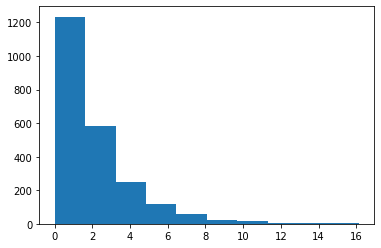

In [40]:
plt.hist(non_zero_distances, bins=10)
plt.show()

### NLG-Eval metrics between ground truth targets and generated/retrieved responses

In [41]:
targets, gen_candidates, ret_candidates = [], [], []
for prediction in log:
    candidates = prediction['candidates']
    gen_candidates_i = [candidate['utterance'] for candidate in candidates
                        if candidate['method'] == 'generated']
    ret_candidates_i = [candidate['utterance'] for candidate in candidates
                        if candidate['method'] == 'retrieved']
    if not len(ret_candidates_i) or not len(gen_candidates_i):
        continue
    targets.append(prediction['target'])
    gen_candidates.append(gen_candidates_i[0])
    ret_candidates.append(ret_candidates_i[0])

In [42]:
NLGEVAL.compute_metrics([targets], gen_candidates)

{'Bleu_1': 0.13726364649020903,
 'Bleu_2': 0.08680134459794313,
 'Bleu_3': 0.06037331869854004,
 'Bleu_4': 0.04342306055229852,
 'METEOR': 0.0968549718873623,
 'ROUGE_L': 0.12435196529410052,
 'CIDEr': 0.33723626046014477}

In [43]:
NLGEVAL.compute_metrics([targets], ret_candidates)

{'Bleu_1': 0.13151891981579006,
 'Bleu_2': 0.08050001819956094,
 'Bleu_3': 0.05591104907626549,
 'Bleu_4': 0.04104445897116139,
 'METEOR': 0.09317024600331747,
 'ROUGE_L': 0.10623854563766852,
 'CIDEr': 0.27015268094444644}

# MetaLWOz cross task

In [44]:
log = logs[1]
distances = get_candidate_distances(log)
non_zero_dist_preds = [(pred, dist) for pred, dist in zip(log, distances) if 1e-7 < abs(dist)]
min_max_preds = get_min_max_candidates(non_zero_dist_preds)
non_zero_distances = [dist for _, dist in non_zero_dist_preds]

In [45]:
print(min(non_zero_distances))
print(max(non_zero_distances))

0.001000000000000112
15.793


### Number of predictions with identical gen and ret candidates

In [46]:
zero_distances_num = len(distances) - len(non_zero_distances)
print('Identical gen/ret predictions: {} ({:.1f}%)'.format(zero_distances_num,
                                                           100.0 * zero_distances_num / len(distances)))

Identical gen/ret predictions: 15 (0.6%)


### Predictions with 10 closest retrieved/generated pairs

In [47]:
min_preds = min_max_preds['min']
for pred, _ in min_preds:
    print_prediction(pred)
    print('')

ID:  c792eb5d
INPUT:
Wizard: Hello how may I help you?
User: help me book a flight
Wizard: do you have a particular place in mind?
User: i hear Greece is nice this time of year. how do i get a flight there?
Wizard: yes, it is; i can book your flights now, if you like
User: wait don't! i am only curious on how to fly there
Wizard: AA Airlines fly to Greece everyday
User: how much is the ticket?
Wizard: we have specials this month for $350 roundtrip
TARGET:
i don't have enough funds. i'll save up
CANDIDATES:
thanks [1.57] [retrieved]
how much is the flight to Germany? [1.569] [generated]

ID:  97b08539
INPUT:
Wizard: Hello how may I help you?
User: Hello bot!
Wizard: Hi, how can I help you?
User: Are there any good festivals in Montreal this summer?
Wizard: Yes there are a few, would you like me to list them?
User: List the best one.
Wizard: In my opinion the best one is the beer festival!
TARGET:
Awesome, I love to drink. How much are tickets.
CANDIDATES:
Okay. I'll go with that. [1.754

### Prediction with the most distant retrieved and generated scores

In [48]:
max_preds = min_max_preds['max']
for pred, _ in max_preds:
    print_prediction(pred)
    print('')

ID:  0e719d2c
INPUT:
Wizard: Hello how may I help you?
User: i need a room
Wizard: Sure, where are you looking for a room at?
User: with 2 bedrooms
Wizard: Okay, I can help with that.
User: andit is located on the second floor of a hotel
Wizard: Okay, what city are you interested in?
User: te specific place is in toronto
Wizard: What date would you like to book the room for?
TARGET:
Next monday
CANDIDATES:
May 16th [2.642] [generated]
Thanks a lot! [-13.151] [retrieved]

ID:  95e4c53a
INPUT:
Wizard: Hello how may I help you?
User: Hey, I've got a question about tourism
Wizard: Sure, I can help with that.
User: I'm curious if there are any bars around here
Wizard: Could you specify your location for me?
TARGET:
Where I am?
CANDIDATES:
I'm in Tampa, I need some info on the best time to visit the city [3.008] [generated]
I need some information about Rome and where to go. [-12.744] [retrieved]

ID:  ade4298d
INPUT:
Wizard: Hello how may I help you?
User: Hi, I need some help booking a hot

### Histogram of distances between the gen/ret candidates' scores

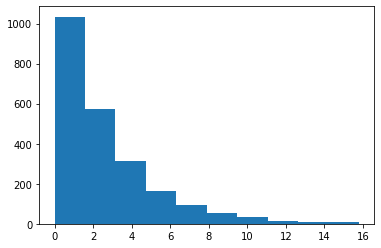

In [49]:
plt.hist(non_zero_distances, bins=10)
plt.show()

### NLG-Eval metrics between ground truth targets and generated/retrieved responses

In [50]:
targets, gen_candidates, ret_candidates = [], [], []
for prediction in log:
    candidates = prediction['candidates']
    gen_candidates_i = [candidate['utterance'] for candidate in candidates
                        if candidate['method'] == 'generated']
    ret_candidates_i = [candidate['utterance'] for candidate in candidates
                        if candidate['method'] == 'retrieved']
    if not len(ret_candidates_i) or not len(gen_candidates_i):
        continue
    targets.append(prediction['target'])
    gen_candidates.append(gen_candidates_i[0])
    ret_candidates.append(ret_candidates_i[0])

In [51]:
NLGEVAL.compute_metrics([targets], gen_candidates)

{'Bleu_1': 0.09306288471808219,
 'Bleu_2': 0.047125813047579346,
 'Bleu_3': 0.025950020477780337,
 'Bleu_4': 0.01443369002824864,
 'METEOR': 0.064603587574131,
 'ROUGE_L': 0.08838798520627565,
 'CIDEr': 0.15563668690877136}

In [52]:
NLGEVAL.compute_metrics([targets], ret_candidates)

{'Bleu_1': 0.07866609662248343,
 'Bleu_2': 0.033152581956752004,
 'Bleu_3': 0.015787743223742993,
 'Bleu_4': 0.007220890436601584,
 'METEOR': 0.05661403847743155,
 'ROUGE_L': 0.06317773412191383,
 'CIDEr': 0.08790478975729037}

# MultiWOZ

In [53]:
log = logs[2]
distances = get_candidate_distances(log)
non_zero_dist_preds = [(pred, dist) for pred, dist in zip(log, distances) if dist is not None and 1e-7 < abs(dist)]
min_max_preds = get_min_max_candidates(non_zero_dist_preds)
non_zero_distances = [dist for _, dist in non_zero_dist_preds]

In [55]:
print(min(non_zero_distances))
print(max(non_zero_distances))

0.0009999999999998899
16.272


### Number of predictions with identical gen and ret candidates

In [56]:
zero_distances_num = len(distances) - len(non_zero_distances)
print('Identical gen/ret predictions: {} ({:.1f}%)'.format(zero_distances_num,
                                                           100.0 * zero_distances_num / len(distances)))

Identical gen/ret predictions: 10 (0.3%)


### Predictions with 10 closest retrieved/generated pairs

In [57]:
min_preds = min_max_preds['min']
for pred, _ in min_preds:
    print_prediction(pred)
    print('')

ID:  SNG1282
INPUT:
Wizard: Hello, how may I help you?
User: i want to book a taxi. The taxi should go to saigon city and should arrive by 24:45.
Wizard: Where will you be departing from?
User: I will be departing from parkside pools.
Wizard: I've booked a grey BMW that will leave Parkside Pools, and arrive in Saigon City by 24:45. Their contact
TARGET:
No thank you. that's all.
CANDIDATES:
That is all. Thank you. [2.784] [retrieved]
That is all. Thank you for your help. [2.783] [generated]

ID:  SNG0518
INPUT:
Wizard: Hello, how may I help you?
User: I am looking for a place to dine. The restaurant should be expensive and should serve Chinese food.
Wizard: Would you like the restaurant in a specific place?
TARGET:
Not in any specific area please. I need to book a table for 3 at 14:00 on Saturday.
CANDIDATES:
Do you have the address? [-1.633] [generated]
I am looking for a restaurant in the centre of town, please. [-1.635] [retrieved]

ID:  SNG0900
INPUT:
Wizard: Hello, how may I help 

### Prediction with the most distant retrieved and generated scores

In [58]:
max_preds = min_max_preds['max']
for pred, _ in max_preds:
    print_prediction(pred)
    print('')

ID:  SNG1313
INPUT:
Wizard: Hello, how may I help you?
User: i am looking for a train. The train should leave on Monday and should arrive by 12:45.
Wizard: Where would you like to go?
TARGET:
I would like to depart from Cambridge, and travel to Bishops Stortford.
CANDIDATES:
i would like to go to Cambridge. [5.253] [generated]
I would like to leave after 09:00 on Sunday. [-11.019] [retrieved]

ID:  SNG02235
INPUT:
Wizard: Hello, how may I help you?
User: I've just been robbed and I need some help.
Wizard: I'm sorry to hear that. There is a police station on Parkside, Cambridge CB11JG and the phone number is
TARGET:
No that will be all, thank you.
CANDIDATES:
What is their postcode? [1.339] [retrieved]
I've just been robbed and I need help to find out where to go. 999 999 999 [-13.922] [generated]

ID:  SSNG0132
INPUT:
Wizard: Hello, how may I help you?
User: I'm looking for a restaurant in the west side that's in the moderate price range.
Wizard: I have three listings, one for british,

### Histogram of distances between the gen/ret candidates' scores

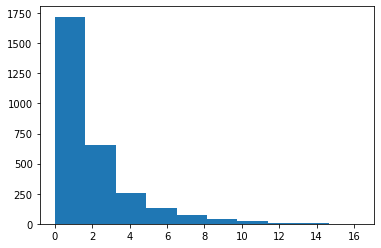

In [59]:
plt.hist(non_zero_distances, bins=10)
plt.show()

### NLG-Eval metrics between ground truth targets and generated/retrieved responses

In [60]:
targets, gen_candidates, ret_candidates = [], [], []
for prediction in log:
    candidates = prediction['candidates']
    gen_candidates_i = [candidate['utterance'] for candidate in candidates
                        if candidate['method'] == 'generated']
    ret_candidates_i = [candidate['utterance'] for candidate in candidates
                        if candidate['method'] == 'retrieved']
    if not len(ret_candidates_i) or not len(gen_candidates_i):
        continue
    targets.append(prediction['target'])
    gen_candidates.append(gen_candidates_i[0])
    ret_candidates.append(ret_candidates_i[0])

In [61]:
NLGEVAL.compute_metrics([targets], gen_candidates)

{'Bleu_1': 0.14956614426962225,
 'Bleu_2': 0.08282631966109044,
 'Bleu_3': 0.05139899333596168,
 'Bleu_4': 0.03199442578837789,
 'METEOR': 0.10809619030515405,
 'ROUGE_L': 0.1534042297185729,
 'CIDEr': 0.2639610583922107}

In [62]:
NLGEVAL.compute_metrics([targets], ret_candidates)

{'Bleu_1': 0.16137468764512178,
 'Bleu_2': 0.08893640718216188,
 'Bleu_3': 0.05564082781116519,
 'Bleu_4': 0.03524461834675368,
 'METEOR': 0.11398352334959967,
 'ROUGE_L': 0.15131759069933493,
 'CIDEr': 0.2815354175802742}